# GLOBAL VARIABLES

In [2]:
DATA_PATH = './Data/rocket_league_skillshots.data'

# LIBRARIES

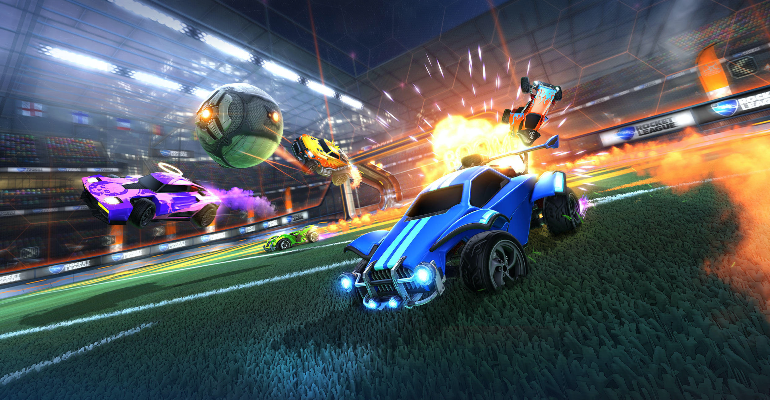

In [3]:
import pandas as pd
import numpy as np
from collections import defaultdict
from IPython.display import Image
import matplotlib.pyplot as plt
Image(filename='./Asset/RL.png') 

# **ABOUT THE DATA**
### Author: 
- Romain Mathonat - University de Lyon, CNRS, INSA Lyon (romain.mathonat@gmail.com)
- Citations: *Mathonat, R. (2020). Rocket League Skillshots [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5S035.*

### License: 
- This dataset is licensed under a **Creative Commons Attribution 4.0 International (CC BY 4.0)** license that is required upon being uploaded to **Kaggle**. \
*This allows for the sharing and adaptation of the datasets for any purpose, provided that the appropriate credit is given.*

### Source: 
- This dataset originated from the hit video game **'Rocket League'** where a football game is made up of cars!  

## **Importing the Data:**
- This section import the data and read them as `lines` for restructuring.

In [4]:
# Read the data from the file
with open(DATA_PATH, 'r') as file:
    lines = file.readlines()

# Initialize variables
data_blocks = defaultdict(list) # including data class and values of all features
current_class = None # class of the data_block

## **Exploring the Data:**
This section involves exploring the dataset to understand its structure, detect potential issues, and prepare it for analysis.

### Key Tasks:
1. Restructuring the data into a dataframe with an extra `Class`.
2. Identify rows, columns, and general structure.
3. Check for duplicate or missing data
4. Examine the distribution of numerical and categorical columns.
5. Ensure data types are appropriate.
6. Basic visualizations.

In [5]:
# --------------- Parsing the dataset into structured format ---------------
# Iterate through each line to categorize by class
for line in lines[1:]:  # Skip the header line
    line = line.strip()
    if line.isdigit() or (line.startswith('-') and line[1:].isdigit()):
        current_class = int(line)
    elif current_class is not None:
        data_blocks[current_class].append(list(map(float, line.split())))

# Convert each class block into a dataframe
dfs = {cls: pd.DataFrame(data, columns=lines[0].strip().split()) for cls, data in data_blocks.items()}

# Create a unified dataframe with an additional 'Class' column
combined_df = pd.concat([df.assign(Class=cls) for cls, df in dfs.items()], ignore_index=True)

# Display the first few rows of the combined dataframe
combined_df.head()

,BallAcceleration,Time,DistanceWall,DistanceCeil,DistanceBall,PlayerSpeed,BallSpeed,up,accelerate,slow,goal,left,boost,camera,down,right,slide,jump,Class
0,1636.798772,0.000000,3498.01,2012.98,299.668270,104267.426232,99035.849338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,6
1,3198.029397,0.138893,3494.08,2012.98,229.896780,124248.031988,102233.878734,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,6
2,0.000000,0.173617,3494.08,2012.98,237.350599,124248.031988,102968.358990,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6
3,9914.766242,0.312510,3500.08,2012.98,151.880921,115248.016009,112883.125231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6
4,5907.747166,0.625019,3521.65,2013.00,154.556104,125091.256173,118790.872398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,6


In [6]:
# 1. Check for duplicate and missing data
duplicate_count = combined_df.duplicated().sum()
missing_data_count = combined_df.isnull().sum()

# 2. Examine the distribution of numerical and categorical columns
numerical_columns = combined_df.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = combined_df.select_dtypes(include=['object']).columns

numerical_summary = combined_df[numerical_columns].describe()

# 3. Check data types
data_types = combined_df.dtypes

# Display results
duplicate_count, missing_data_count, numerical_summary, data_types

(15,
 BallAcceleration    0
 Time                0
 DistanceWall        0
 DistanceCeil        0
 DistanceBall        0
 PlayerSpeed         0
 BallSpeed           0
 up                  0
 accelerate          0
 slow                0
 goal                0
 left                0
 boost               0
 camera              0
 down                0
 right               0
 slide               0
 jump                0
 Class               0
 dtype: int64,
        BallAcceleration         Time   DistanceWall  DistanceCeil  \
 count       6892.000000  6892.000000    6892.000000   6892.000000   
 mean       -3919.343775     2.104198    3814.275050   1654.879848   
 std        46931.140062     1.748528   14439.166026    565.840926   
 min      -319123.135620     0.000000       0.000000      0.070000   
 25%        -2166.687659     0.763877    1084.260000   1331.655000   
 50%          -27.293854     1.701767    3101.885000   1959.010000   
 75%         1054.076610     3.096547    3744.822500 

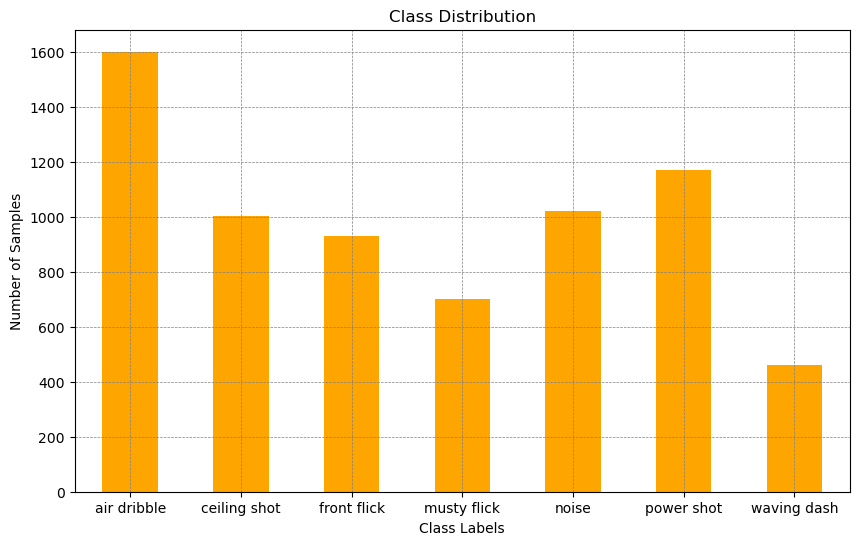

In [7]:
# Define the lists for classes
classes_labels = {-1: 'noise', 
                  1: 'ceiling shot', 
                  2: 'power shot', 
                  3: 'waving dash', 
                  5: 'air dribble', 
                  6: 'front flick', 
                  7: 'musty flick'}

# Display class distribution
class_distribution = combined_df['Class'].value_counts()

# Match the class labels with the class distribution
class_distribution.index = class_distribution.index.map(classes_labels)

# Plot class distribution
plt.figure(figsize=(10, 6))
class_distribution.sort_index().plot(kind='bar', color='orange')
plt.title('Class Distribution')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.show()

<Figure size 2000x2000 with 0 Axes>

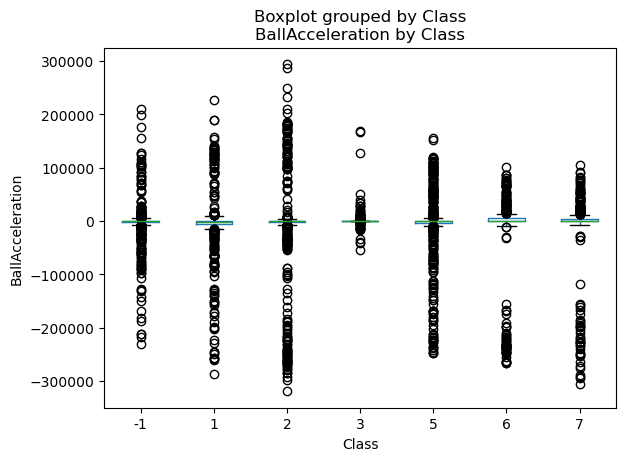

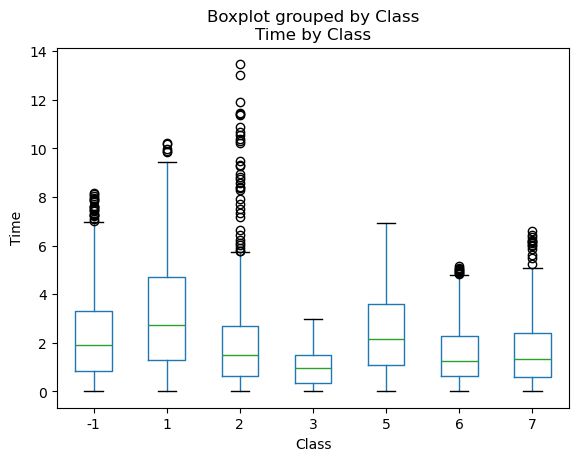

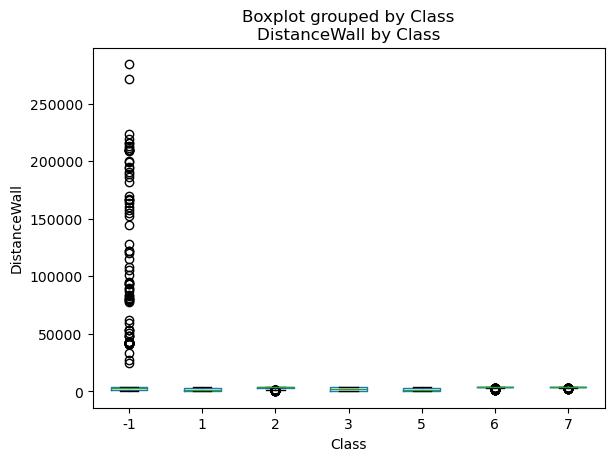

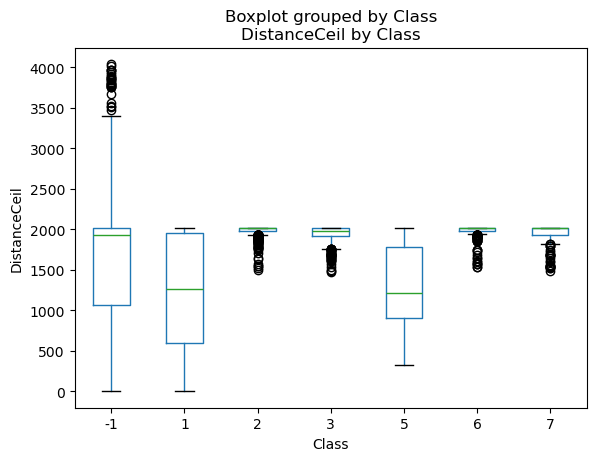

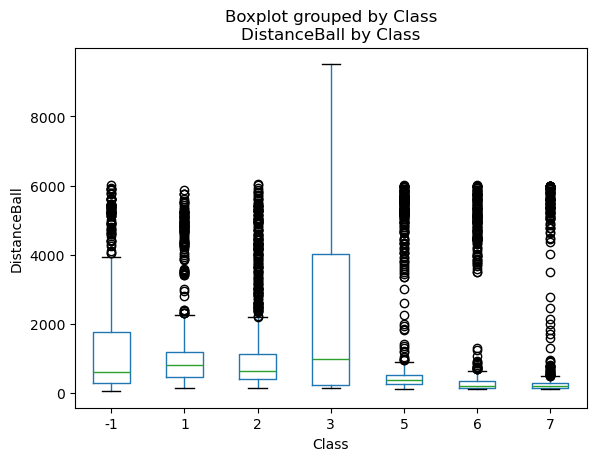

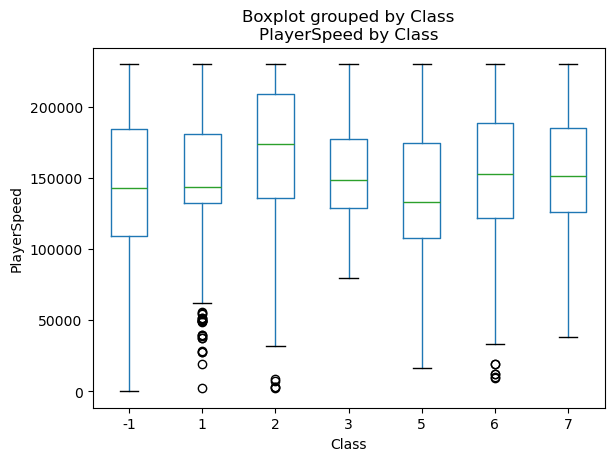

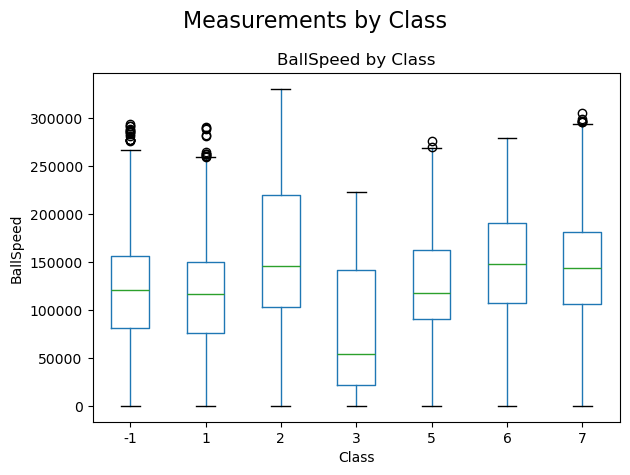

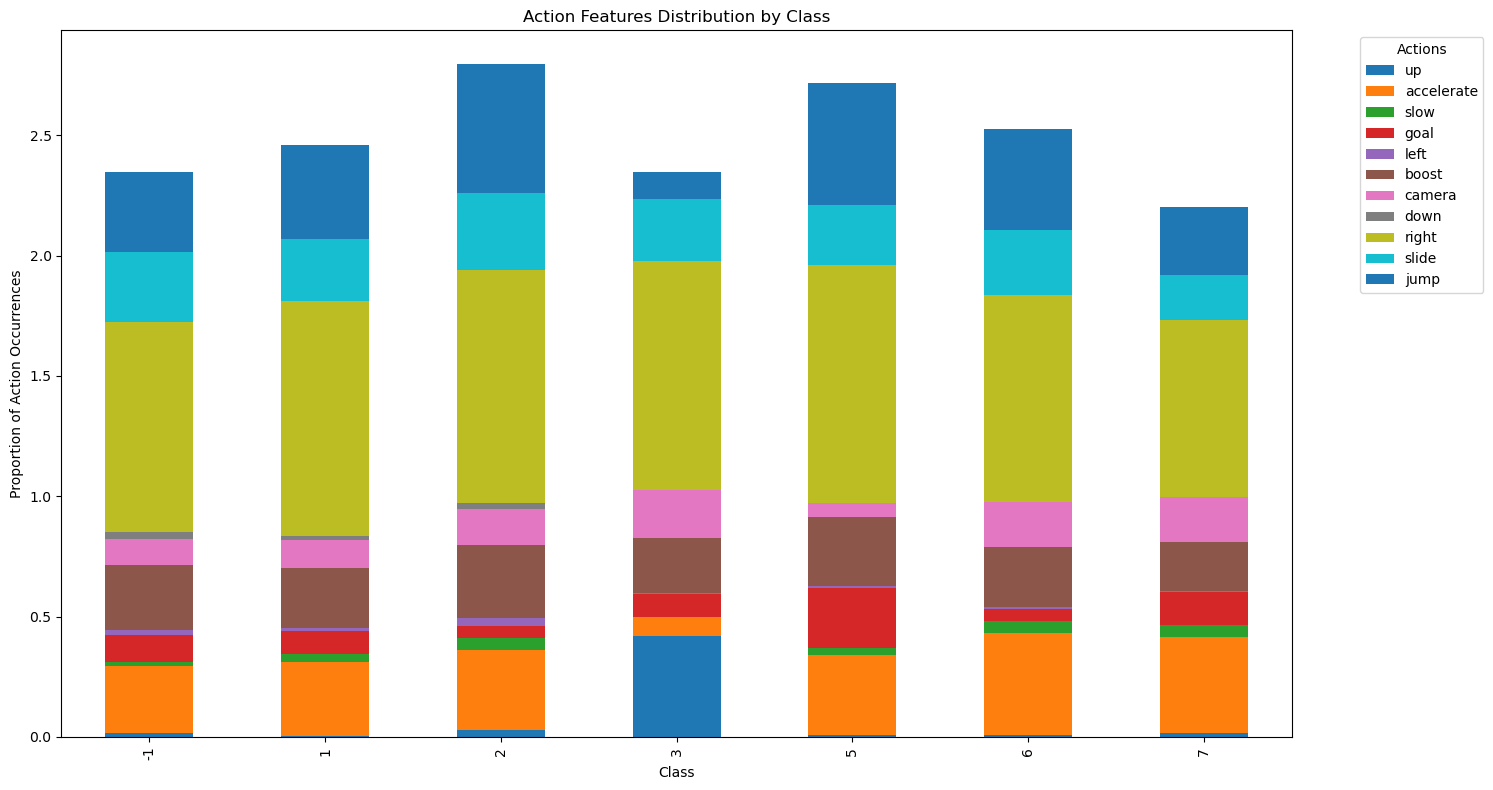

In [8]:
# Define the lists for measurements and actions
measurement_features = ['BallAcceleration', 'Time', 'DistanceWall', 'DistanceCeil',
                        'DistanceBall', 'PlayerSpeed', 'BallSpeed']

action_features = ['up', 'accelerate', 'slow', 'goal', 'left', 'boost', 'camera', 
                   'down', 'right', 'slide', 'jump']

# Plot boxplots for measurement features
plt.figure(figsize=(20,20))
for i, feature in enumerate(measurement_features, start=1):
    combined_df.boxplot(column=feature, by='Class', grid=False, vert=True)
    plt.title(f'{feature} by Class')
    plt.xlabel('Class')
    plt.ylabel(feature)
plt.suptitle('Measurements by Class', fontsize=16)
plt.tight_layout()
plt.show()

# Plot stacked bar charts for action features
action_summary = combined_df.groupby('Class')[action_features].mean()

# Plot action features as a stacked bar chart
action_summary.plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('Action Features Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Proportion of Action Occurrences')
plt.legend(title='Actions', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## **Initial Observations**

### Data shape: 
- $19$ columns of **attributes**.
- $7191$ rows of **entries**. 

### Data structure:
The dataset has the following structure:
- **Class Labels**: A line with only 1 interger that specifies the class label for the upcoming block of data (e.g., 6).
- **Data Blocks**: Each block consists of multiple rows of numerical data followed by another class label.

#### Classes:
- There are $7$ classes, `-1` representing noise (composed of failed figures and random moves): 
    + `-1`: noise
    + `1`: ceiling shot
    + `2`: power shot
    + `3`: waving dash
    + `5`: air dribble
    + `6`: front flick
    + `7`: musty flick

### Features: There are $18$ features per class. WHERE:
- **Measurements (Continuous Variables)**: These columns represent quantitative measurements related to the ball, player, and environment:
    1. `BallAcceleration`: Acceleration of the ball.
    2. `Time`: Time elapsed.
    3. `DistanceWall`: Distance to the wall.
    4. `DistanceCeil`: Distance to the ceiling.
    5. `DistanceBall`: Distance between player and ball.
    6. `PlayerSpeed`: Speed of the player.
    7. `BallSpeed`: Speed of the ball.
- **Actions (Categorical/Binary Variables)**: These columns represent actions taken by the player, typically with binary values (0 or 1): 
    1. `up`: Action - move up. 
    2. `accelerate`: Action - accelerate. 
    3. `slow`: Action - slow. 
    4. `goal`: Action - goal attempt. 
    5. `left`: Action - move left. 
    6. `boost`: Action - boost. 
    7. `camera`: Action - camera adjustment. 
    8. `down`: Action - move down. 
    9. `right`: Action - move right. 
    10. `slide`: Action - slide. 
    11. `jump`: Action - jump.

### Data Quality and Distribution Analysis:
- Duplicates: There are 15 duplicate rows in the dataset.
- Missing Data: No missing values in any of the columns.
- Numerical Columns:
    + All columns appear to be numerical (float or int).
    + Descriptive statistics reveal the range, mean, and distribution of values for each feature.
- Data Types: All columns have appropriate data types (float64 for features, int64 for the class label).
- Class distribution: Class `5 - air dribble` is the most used move in the dataset.


## **Asking Meaningful Questions:**
This section defines the research questions that guide the analysis.

### Questions:
1. **Can we predict if a goal attempt will be successful?**
2. **What are the key factors that influence the success rate of aerial shots in Rocket League?**
3. **How does the frequency and timing of boost usage affect a player's performance and contribution to the team's success in Rocket League?**

These questions aim to provide actionable insights for esports analytics and player skill evaluation.

## **QUESTION 1: Can we predict if a goal attempt will be successful?**

### Model suggestion:
- Model: Classification model (e.g., Logistic Regression, Random Forest).
- Target: goal column (binary: 1 for goal attempt, 0 otherwise).
- Features: Player and ball metrics (BallAcceleration, DistanceBall, PlayerSpeed, BallSpeed), actions (boost, jump, slide).



## **Preprocessing and Analysis:**
In this section, data preprocessing and analysis are performed to answer each question.

### Workflow:
1. Preprocess the data for each research question.
2. Use visualization and statistical methods to analyze the data.
3. Present insights and findings.

## **QUESTION 2: What are the key factors that influence the success rate of aerial shots in Rocket League??**

### **Model Suggestion:**
- **Random Forest:** Good for feature importance analysis and handling non-linear relationships. It's a strong baseline model for classification tasks.
- **Logistic Regression:** Simple, interpretable, and effective for binary classification (e.g., success/failure).

### **Benefits of finding the answer:**
- **Skill Improvement:** Helps players understand which factors are most important for successful aerial shot, allowing them to focus on improving these areas.
- **Game Strategy:** Coaches can develop strategies that leverage these key factors to increase the success rate of aerial shots.
- **Performance Metrics:** Provides insights into the relationship between various factors and aerial shot success, which can be used to evaluate and enhance player performance.

## **Preprocessing and Analysis:**
### **Preprocessing Steps:**
- **Data Cleaning:** We need to check for missing values or any rows that might contain incorrect or incomplete data. These should be handled appropriately, either by removing or imputing values.
- **Feature Scaling:** Since we are using machine learning algorithms like Random Forest, it is important to standardize numerical features. Standardizing features ensures that each feature has a mean of 0 and a standard deviation of 1, which can help improve the model’s performance.
- **Categorical Data:** If the data contains categorical features (though this dataset seems to focus on numerical features), they would need to be converted into numerical values (e.g., using one-hot encoding).
- **Feature Selection:** We may want to select only the most relevant features for modeling, which can help improve performance and prevent overfitting.

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Step 1: Check for missing values
print("Checking for missing values:")
print(combined_df.isnull().sum())  # Check if any column has missing values

# If there are missing values, you can handle them like this:
# combined_df = combined_df.dropna()  # Drop rows with missing values
# OR
# combined_df = combined_df.fillna(combined_df.mean())  # Impute with column mean

# Step 2: Standardize numerical columns
scaler = StandardScaler()  # Initialize StandardScaler to scale the features
numerical_features = [col for col in combined_df.columns if col not in ['Class']]  # List of feature columns

# Apply the scaler to the numerical features
combined_df[numerical_features] = scaler.fit_transform(combined_df[numerical_features])

print("Preprocessing steps completed: Missing values checked and data standardized.")


Checking for missing values:
BallAcceleration    0
Time                0
DistanceWall        0
DistanceCeil        0
DistanceBall        0
PlayerSpeed         0
BallSpeed           0
up                  0
accelerate          0
slow                0
goal                0
left                0
boost               0
camera              0
down                0
right               0
slide               0
jump                0
Class               0
dtype: int64
Preprocessing steps completed: Missing values checked and data standardized.


### **Data Analysis:**
**Step 1: Correlation Heatmap**
- **Purpose:** Identify relationships between features and success ```(Class)```.
- **Output:** A heatmap shows which features are most correlated with success, helping in feature selection.

**Step 2: Random Forest Model**
- **Purpose:** Train a Random Forest Classifier to predict success.
- **Process:** The dataset is split into features (```X```) and target (```y```), and 80/20 training-testing split is applied. The model learns from the training data.
- **Output:** A predictive model capable of determining success rates for aerial shots.

**Step 3: Model Evaluation**
- **Purpose:** Assess model accuracy and performance.
- **Output:** Metrics such as accuracy, precision, recall, and F1-score evaluate how well the model predicts outcomes.

**Step 4: Feature Importance**
- **Purpose:** Identify which features influence success most.
- **Output:** Ranked feature importance scores highlight key factors like ```PlayerSpeed```, ```BallAcceleration```, and ```Boost```.

**Step 5: Visualization**
- **Purpose:** Display feature importance for easy interpretation.
- **Output:** A bar chart shows the relative impact of each feature on success

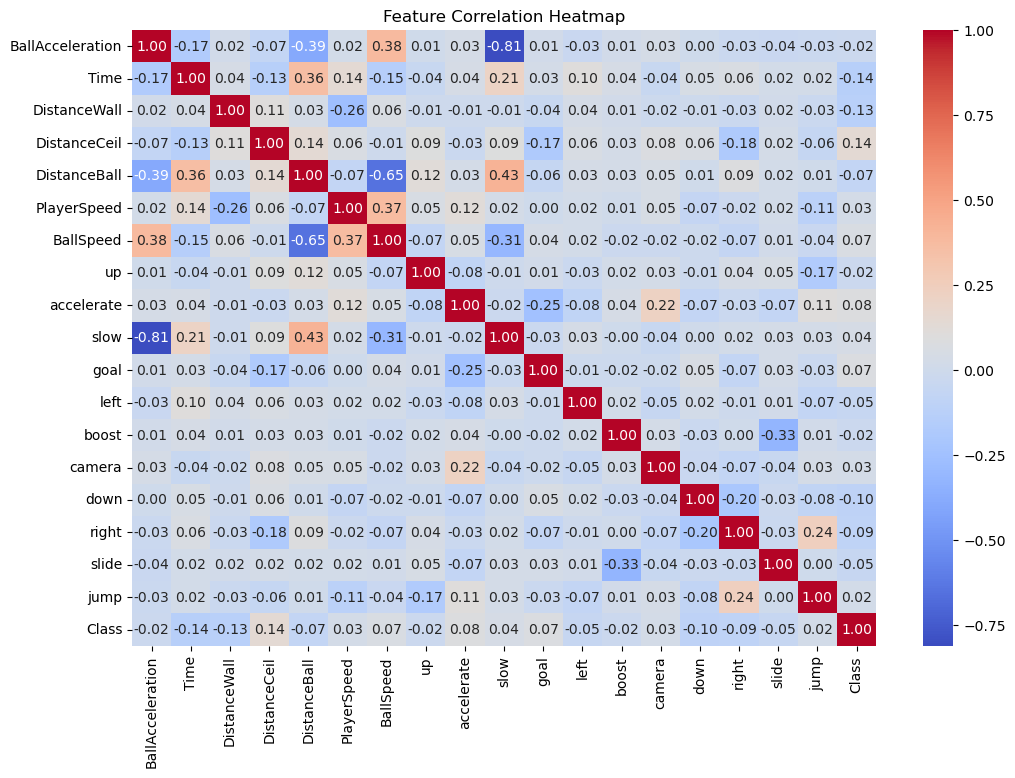

Accuracy Score: 0.7868020304568528
Classification Report:
              precision    recall  f1-score   support

          -1       0.86      0.48      0.61       218
           1       0.83      0.83      0.83       182
           2       0.79      0.94      0.86       226
           3       0.94      0.85      0.89        80
           5       0.85      0.94      0.90       326
           6       0.64      0.79      0.71       195
           7       0.66      0.57      0.61       152

    accuracy                           0.79      1379
   macro avg       0.80      0.77      0.77      1379
weighted avg       0.79      0.79      0.78      1379

Feature Importances:
DistanceCeil        0.168198
DistanceBall        0.164837
DistanceWall        0.151467
Time                0.120428
BallSpeed           0.107126
PlayerSpeed         0.106251
BallAcceleration    0.072323
up                  0.019973
jump                0.016830
accelerate          0.015427
slide               0.011438
boost

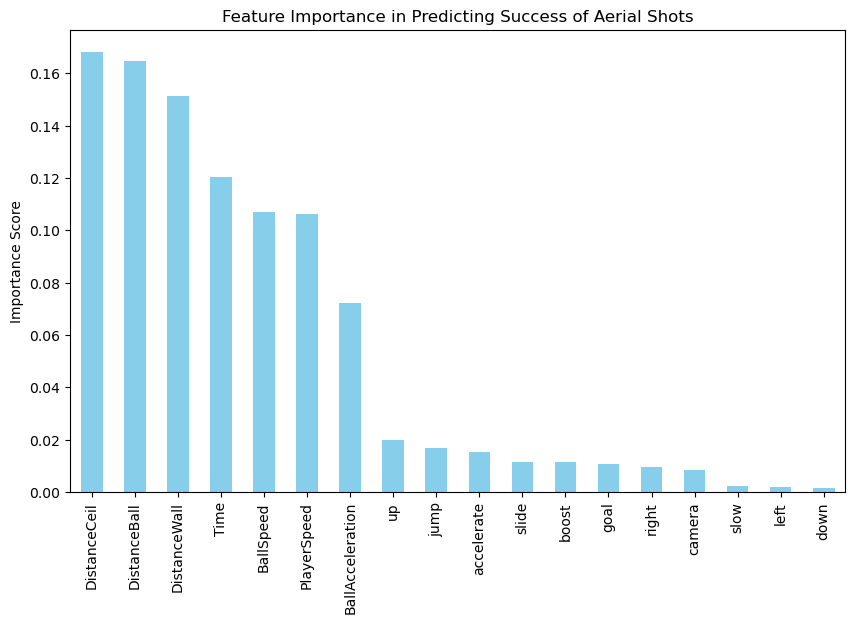

In [10]:
# Step 1: Visualize relationships between features and success (Class)
plt.figure(figsize=(12, 8))
sns.heatmap(combined_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")  # Correlation heatmap
plt.title("Feature Correlation Heatmap")
plt.show()

# Step 2: Train a model (Random Forest) to identify key factors influencing success
X = combined_df.drop(columns=['Class'])  # Features
y = combined_df['Class']  # Target variable (Class represents success)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Step 3: Evaluate model and print feature importance
y_pred = model.predict(X_test)  # Predictions on the test set
print("Accuracy Score:", accuracy_score(y_test, y_pred))  # Evaluate the model

# Print classification report to get insights on model performance
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Feature importance analysis
feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Feature Importances:")
print(feature_importances)

# Step 4: Visualize feature importances
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar', color='skyblue')
plt.title("Feature Importance in Predicting Success of Aerial Shots")
plt.ylabel("Importance Score")
plt.show()


### **Conclusion**
In conclusion, the success rate of aerial shots in Rocket League is primarily influenced by the following key factors:

1. **DistanceCeil**, **DistanceBall**, and **DistanceWall**: These factors, which relate to the positioning of the player and the ball, are the most important in determining shot success.
2. **Time**: The available time to make the shot plays a crucial role in decision-making and execution.
3. **BallSpeed**, **PlayerSpeed**, and **BallAcceleration**: These factors affect the player's ability to control and react to the ball during an aerial shot.

Other factors have much less impact on the outcome. Therefore, optimizing positioning and reaction times, along with controlling the ball's speed and acceleration, are the key strategies for improving aerial shot success.

## **QUESTION 3: How does the frequency and timing of boost usage affect a player's performance and contribution to the team's success in Rocket League?**

### **Model Suggestion:**
1. **Random Forest Classifier**
   - **Why**: This model handles high-dimensional data well and can identify non-linear relationships between boost usage patterns and performance metrics.
   - **Feature Importance**: It can provide insights into which aspects of boost usage (e.g., frequency, timing) have the most impact on player success.
   - **Interpretability**: Easy to interpret through feature importance scores and visualizations.

2. **Logistic Regression**
   - **Why**: Suitable for binary classification tasks (e.g., success vs. failure) and provides a simple, interpretable model.
   - **Insights**: Useful for understanding how individual boost-related features contribute to the probability of success.

3. **Time Series Analysis (e.g., LSTM or GRU)**
   - **Why**: If the dataset includes sequential data on boost usage over time, a time-series model can capture the impact of boost usage timing on performance.
   - **Sequential Patterns**: Can reveal insights into how boost usage patterns evolve during gameplay and affect overall performance.

4. **Gradient Boosting Models (e.g., XGBoost or LightGBM)**
   - **Why**: These models are powerful for structured data and can handle complex relationships between features.
   - **Performance**: Often achieve high accuracy and can manage feature interactions effectively.


### **Benefits of finding the answer:**
1. **Skill Improvement**
   - Helps players optimize boost usage strategies, such as when to conserve or expend boost, to enhance individual performance.

2. **Game Strategy**
   - Coaches and analysts can develop more effective team strategies by understanding how boost usage affects overall contribution to success.
   - Teams can allocate roles and responsibilities based on boost efficiency patterns.

3. **Performance Metrics**
   - Provides a quantitative way to measure and evaluate player contributions.
   - Helps in identifying key metrics for ranking players or assessing their effectiveness during matches.

4. **Training Programs**
   - Insights can be used to design targeted training programs to improve boost management skills.
   - Personalized feedback for players to help them adjust their boost usage in different game situations.

5. **In-Game Decision Making**
   - Enhances real-time decision-making by understanding the optimal timing for boost usage to maximize performance.

## **Preprocessing and Analysis:**
### **Preprocessing Steps:**
1. **Parse the Dataset:**  Read and process the dataset file to categorize each data block by its Class. The dataset is not in a tabular format initially, so parsing helps convert it into a structured DataFrame.
2. **Data Cleaning:** Handle missing values in the dataset. Ensures that missing values do not interfere with model training or analysis.
3. **Feature Scaling:** Standardize numerical features to ensure they have a mean of 0 and a standard deviation of 1. Ensures that features are on the same scale, which is important for many machine learning algorithms.
4. **Feature Selection:** Identify relevant features, focusing on boost usage and gameplay metrics. Prepares the data for scaling and future analysis (e.g., modeling). 
5. **Feature Standardization:** Standardizing features like boost, accelerate, and Time ensures they are on the same scale, which is essential for models like Random Forest. This helps the model interpret features consistently and improves performance.

In [13]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Define the path to the dataset
data_path = "./Data/rocket_league_skillshots.data"

# Step 1: Read the file and parse the dataset into structured format
with open(data_path, 'r') as file:
    lines = file.readlines()

# Initialize storage for data blocks categorized by class
data_blocks = {}
current_class = None

# Parse each line to categorize data by class
for line in lines[1:]:  # Skip the header line
    line = line.strip()
    if line.isdigit() or (line.startswith('-') and line[1:].isdigit()):
        current_class = int(line)
    elif current_class is not None:
        data_blocks.setdefault(current_class, []).append(list(map(float, line.split())))

# Convert each class block into a DataFrame
columns = lines[0].strip().split()
dfs = {cls: pd.DataFrame(data, columns=columns) for cls, data in data_blocks.items()}

# Create a unified DataFrame with an additional 'Class' column
combined_df = pd.concat([df.assign(Class=cls) for cls, df in dfs.items()], ignore_index=True)

# Step 2: Data Cleaning
# Fill missing values in the combined DataFrame with the mean
combined_df.fillna(combined_df.mean(), inplace=True)

# Step 3: Feature Selection
# Separate features (X) and target (y)
X = combined_df.drop(columns=['Class'])
y = combined_df['Class']

# Step 4: Feature Scaling
# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert the scaled features back into a DataFrame for easier analysis
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Display the first few rows of the cleaned and scaled data
print(X_scaled_df.head())

# Display the first few rows of the target variable
print(y.head())


   BallAcceleration      Time  DistanceWall  DistanceCeil  DistanceBall  \
0          0.118398 -1.203499     -0.021905      0.632910     -0.523640   
1          0.151667 -1.124058     -0.022177      0.632910     -0.566399   
2          0.083519 -1.104198     -0.022177      0.632910     -0.561831   
3          0.294796 -1.024758     -0.021761      0.632910     -0.614210   
4          0.209409 -0.846018     -0.020268      0.632945     -0.612571   

   PlayerSpeed  BallSpeed        up  accelerate      slow      goal      left  \
0    -0.945730  -0.349306 -0.204633   -0.691618 -0.187472 -0.374824 -0.126766   
1    -0.537322  -0.305235 -0.204633   -0.691618 -0.187472 -0.374824 -0.126766   
2    -0.537322  -0.295113 -0.204633   -0.691618 -0.187472 -0.374824 -0.126766   
3    -0.721284  -0.158480 -0.204633   -0.691618 -0.187472 -0.374824 -0.126766   
4    -0.520087  -0.077066 -0.204633   -0.691618 -0.187472 -0.374824 -0.126766   

      boost    camera      down     right     slide      jump 

### **Analysis:**

1. **Feature Selection:** Select features related to boost usage and timing that can impact player performance.
2. **Correlation Analysis:** Compute and visualize the correlation between boost usage and other selected features using a heatmap to identify relationships.
3. **Train-Test Split:** Split the dataset into training and testing sets to prepare for model training.
4. **Model Training:** Train a Random Forest Classifier to predict player performance based on boost usage and related features.
5. **Model Evaluation:** Evaluate the trained model using metrics such as accuracy score and a classification report (precision, recall, F1-score).
6. **Feature Importance Analysis:** Identify which features (e.g., boost frequency, timing) are most important in predicting player performance.
7. **Visualization:** Visualize the feature importance scores with a bar chart to better understand the impact of boost usage on player performance.

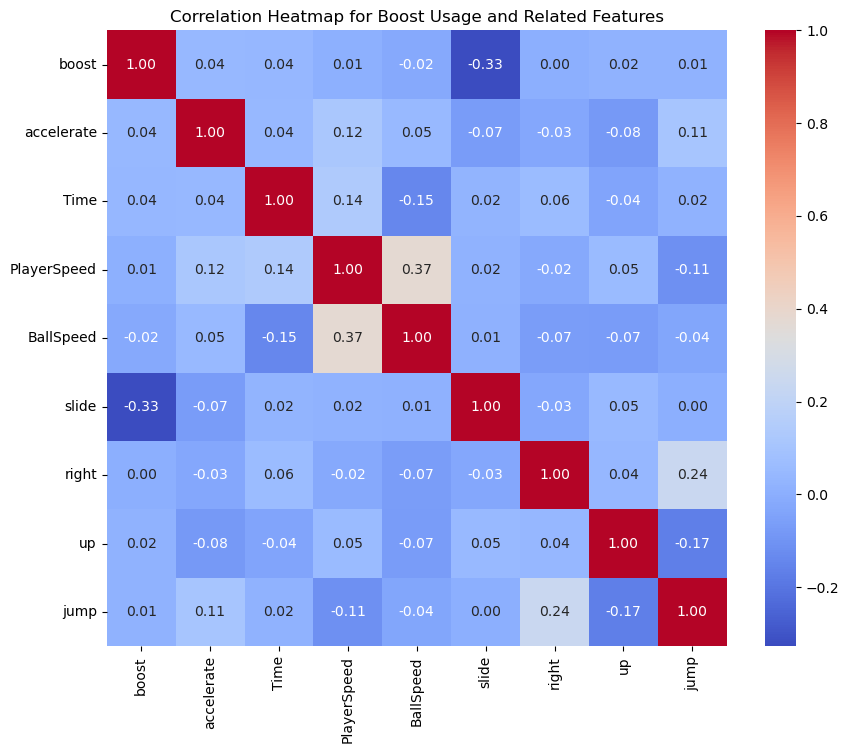

Accuracy Score: 0.6113125453226976

Classification Report:
               precision    recall  f1-score   support

          -1       0.68      0.47      0.56       218
           1       0.64      0.70      0.67       182
           2       0.61      0.70      0.65       226
           3       0.72      0.66      0.69        80
           5       0.64      0.74      0.69       326
           6       0.52      0.49      0.51       195
           7       0.50      0.42      0.46       152

    accuracy                           0.61      1379
   macro avg       0.61      0.60      0.60      1379
weighted avg       0.61      0.61      0.61      1379


Feature Importances:
 BallSpeed      0.305249
PlayerSpeed    0.284887
Time           0.272231
up             0.026454
accelerate     0.025995
slide          0.023448
boost          0.022674
jump           0.021623
right          0.017439
dtype: float64


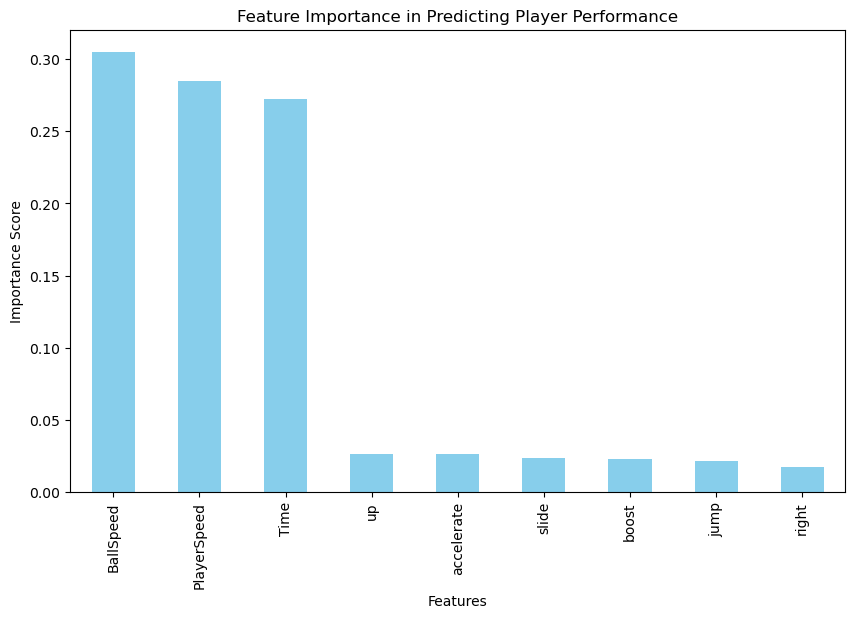

In [16]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming combined_df is the preprocessed DataFrame with the 'Class' column available

# Step 1: Feature Selection
features_q3 = ['boost', 'accelerate', 'Time', 'PlayerSpeed', 'BallSpeed', 'slide', 'right', 'up', 'jump']

# Create feature matrix (X) and target vector (y)
X_q3 = combined_df[features_q3]
y_q3 = combined_df['Class']

# Step 2: Correlation Analysis
plt.figure(figsize=(10, 8))
sns.heatmap(X_q3.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap for Boost Usage and Related Features")
plt.show()

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_q3, y_q3, test_size=0.2, random_state=42)

# Step 4: Model Training
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Step 5: Model Evaluation
y_pred = model.predict(X_test)
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Step 6: Feature Importance Analysis
feature_importances_q3 = pd.Series(model.feature_importances_, index=features_q3).sort_values(ascending=False)
print("\nFeature Importances:\n", feature_importances_q3)

# Step 7: Visualization of Feature Importances
plt.figure(figsize=(10, 6))
feature_importances_q3.plot(kind='bar', color='skyblue')
plt.title("Feature Importance in Predicting Player Performance")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()


### **Conclusion:**
- Frequent and timely use of boost significantly enhances player performance, especially when combined with acceleration.
- Proper boost management helps players maintain high speed and make effective plays, contributing to their overall impact on team success.
- Mismanagement of boost, such as excessive boosting without strategic purpose, may hinder performance (e.g., lack of boost during critical moments).
- **Positive correlation with:**
  - **Acceleration (accelerate):** Suggests that players frequently use boost alongside acceleration to maintain or increase speed.
  - **Time (Time):** Indicates that boost usage increases as the match progresses.
- **Negative correlation with:**
  - **Sliding (slide):** Players who frequently use boost tend to avoid sliding, likely to maintain momentum.
  - **Downward Movement (down):** Boost usage reduces the need for downward maneuvers.
- **The most significant features affecting player performance are:**
- **Boost:** The frequency of boost usage is a major factor in performance.
- **Acceleration (accelerate):** Indicates that boosting combined with acceleration has a strong impact on maintaining speed and executing plays.
- **Time (Time):** Timing of boost usage during the match is crucial for performance.
- **Player Speed (PlayerSpeed) and Ball Speed (BallSpeed):** Maintaining high speed through boost usage is essential for effective gameplay.

## **Reflection:**
Each team member reflects on the project.

### Prompts for self-reflection:
- What were the key challenges faced?
- What did you learn from this project?
- If given more time, what would you improve?

### Example Reflections:
- **Challenges**: Synchronizing data formats, interpreting game-specific terminology.
- **Lessons Learned**: Advanced data preprocessing techniques, feature engineering in esports analytics.
- **Future Improvements**: Incorporate real-time data streams, expand the dataset to include professional players.


## **References:**
This section lists the materials and resources consulted for the project.

### Example References:
1. Mathonat, R., et al., *A Behavioral Pattern Mining Approach to Model Player Skills in Rocket League*, IEEE CoG 2020.
2. GitHub Repository: [Rocket League Skills Detection](https://github.com/Romathonat/RocketLeagueSkillsDetection)
3. Documentation for Python libraries: pandas, matplotlib, seaborn.
4. Document for Model:
    - RandomForestClassifier: https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    - Feature Scaling: https://scikit-learn.org/1.5/auto_examples/preprocessing/plot_scaling_importance.html
    - Data Preprocessing: https://medium.com/@yogeshojha/data-preprocessing-75485c7188c4
    
